In [8]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import get_cmap
import seaborn as sns
import string
import pickle # save data frame (results) in a .pkl file
import pandas as pd
from datetime import datetime
import os, sys
import re


sys.path.insert(0, 'C:/Users/User/Code/MMDGraph')
#from importlib import reload
from mmdutils import readfoldertopanda, PlotROCGeneral, plotVaryingBGDEG, findAUC
#reload(readfoldertopanda)
import importlib
importlib.reload(sys.modules['mmdutils'])
from mmdutils import readfoldertopanda, PlotROCGeneral, plotVaryingBGDEG, findAUC

In [9]:
keys = ['nr_nodes_1', 'nr_nodes_2', 'degree_1','degree_2', 'n', 'm']
params_kernel = {}
data_auc = {}
data = {}

# Graph Stats

In [10]:
GRAPHSTATS = readfoldertopanda("../data/BGDegreeLabel/GRAPHSTATS")
GRAPHSTATS.columns
#np.unique(GRAPHSTATS['nr_nodes_1'])

Index(['alpha', 'nr_nodes_1', 'nr_nodes_2', 'p_edge_1', 'p_edge_2', 'degree_1',
       'degree_2', 'ratio_p', 'ratio_degree', 'n', 'm', 'timestap', 'B', 'N',
       'run_time', 'average_degree', 'median_degree', 'avg_neigh_degree',
       'avg_clustering', 'transitivity', 'kernel', 'normalize'],
      dtype='object')

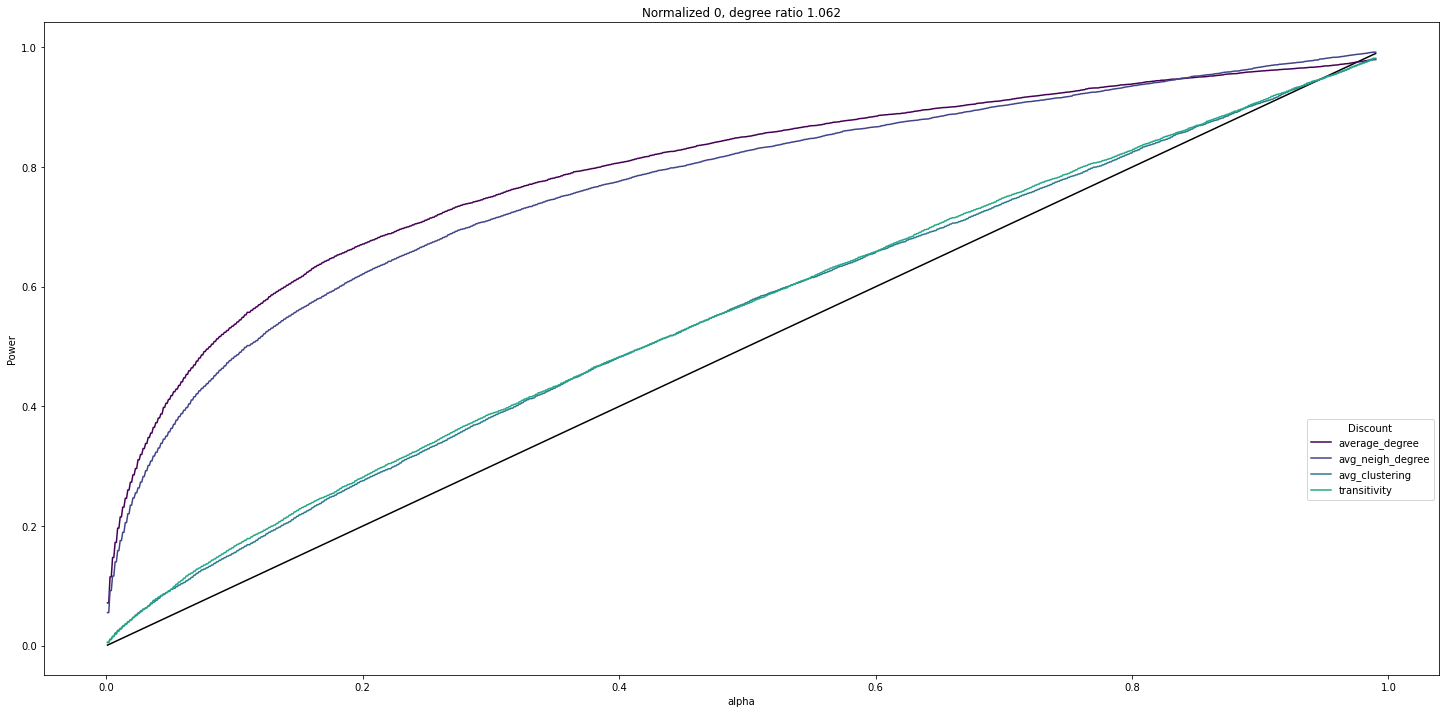

In [11]:
df = GRAPHSTATS
normalize = 0
v = 1.062
n1 = 20
n2 = n1
nr_nodes_1 = 60
nr_nodes_2 = nr_nodes_1

_, ax = plt.subplots(figsize = (25,12))


label = []
#icefire
cmap = get_cmap(sns.color_palette("viridis", as_cmap=True)) # type: matplotlib.colors.ListedColormap
colors = cmap.colors[::int(len(cmap.colors)/(4+1))]  # type: list

ab_line_plotted = False
graph_statistic_plotted = False


tmp = df.loc[(df['ratio_degree'] == v) & (df['n'] == n1) & (df['m'] == n2) & (df['nr_nodes_1'] == nr_nodes_1) & (df['nr_nodes_2'] == nr_nodes_2) & (df['N'] == 10000) ]

x = tmp['alpha']
if len(x)>0:
        ax.plot(x, x, color = 'black')
        ab_line_plotted = True



ax.plot(x, tmp['average_degree'], color =colors[0], label=str(v))
label.append('average_degree')

ax.plot(x, tmp['avg_neigh_degree'], color =colors[1], label=str(v))
label.append('avg_neigh_degree')

ax.plot(x, tmp['avg_clustering'], color =colors[2], label=str(v))
label.append('avg_clustering')

ax.plot(x, tmp['transitivity'], color =colors[3], label=str(v))
label.append('transitivity')



#ax.legend(label)
h, l = ax.get_legend_handles_labels()

ax.legend(handles=h, labels=label, 
        handler_map = {tuple: matplotlib.legend_handler.HandlerTuple(None)}, title = 'Discount', bbox_to_anchor=(1, 0.4))

ax.set_xlabel('alpha')
ax.set_ylabel('Power')
ax.set_title(f'Normalized {normalize}, degree ratio {v}')


plt.show()

In [12]:
GRAPHSTAT_AUC = findAUC(keys = keys, params = [], stats = ['average_degree'], df = GRAPHSTATS )

# WL

Let's see how the WL iterations affect the power

In [13]:
def readfoldertopandaWL(path):
    """
    Read files in a folder and concatenate them into an pandas data frame


    """
    onlyfiles = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

    # read and append
    df = []
    cnt = 0
    for file in onlyfiles:
        tmp = pd.read_pickle(os.path.join(path, file))
        ok = file.rsplit("norm", 1)[-1]
        norm = int(re.findall(r'\d+', ok)[0])
        tmp['normalize'] = norm
        df.append(tmp)
        if cnt < 10:
            print(f'norm is {norm}')
            cnt += 1

    return pd.concat(df)

def get_wl_iteration(string_list):
    numbers_list = np.zeros(len(string_list))
    for i, input_string in enumerate(string_list):
        ok = input_string.rsplit("'n_iter'", 1)[-1]
        numbers_list[i] = int(re.findall(r'\d+', ok)[0])
    
    return numbers_list
            

In [14]:
WL = readfoldertopandaWL("../data/BGDegreeLabel/WLsubtree")
WL['wl_itr'] = get_wl_iteration(WL['kernel'])
WL = WL.loc[(WL['N'] == 10000) | (WL['N'] == 3000)]


norm is 1
norm is 1
norm is 1
norm is 1
norm is 1
norm is 1
norm is 1
norm is 1
norm is 1
norm is 1


In [15]:
# Because of some changes I created different coumns for same parameter. I need to put all the information into one parameter

WL.loc[WL['nitr'].isna(), 'nitr'] = WL.loc[WL['nitr'].isna(), 'wl_itr']

In [16]:
sorted(np.unique(WL['nr_nodes_1']))

[60]

C:/Users/User/Code/MMDGraph\mmdutils.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[param_vary_name].fillna(value=99999, inplace=True)


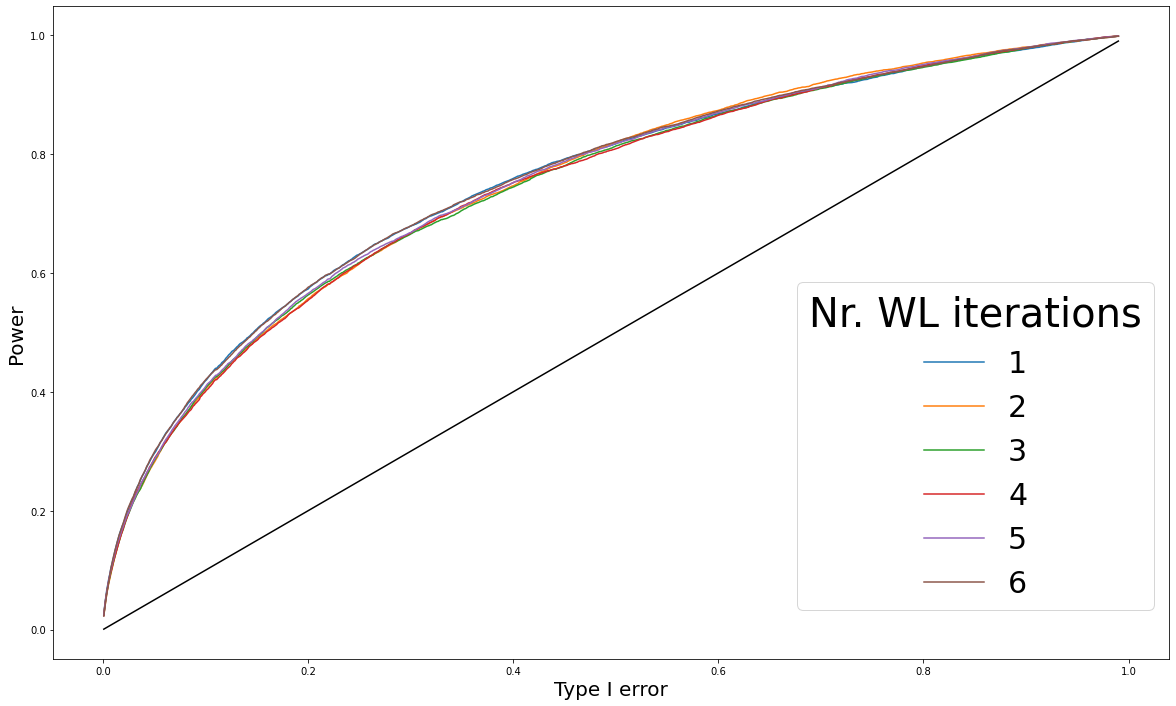

In [17]:

WL['normalize'].loc[WL['N'] == 10000] = 0
data['WL'] = WL
params_fixed = {'ratio_degree':1.062,
                'n':20,
                'm':20,
                'nr_nodes_1':60,
                'nr_nodes_2':60,
                'N':10000,
                #'nitr':4
                'normalize':0
                }


plotVaryingBGDEG(df = WL.copy(), param_vary_name = "nitr", params_fixed = params_fixed, mmd_stat = "MMD_u", color_name = "tab10", disp_title=False, legend_title= 'Nr. WL iterations')



For each unique row (number of samples, number of nodes, average degree combination), find best parameter combination, by calculating the area under the curve

In [18]:
params_kernel['WL'] = ['nitr', 'normalize']
data_auc['WL'] = findAUC(keys = keys, params = params_kernel['WL'], stats = ['MMD_b', 'MMD_u'], df = WL.loc[WL['N'] == 10000] )

# RW

In [19]:
RW = readfoldertopanda("../data/BGDegreeLabel/RW")
RW.columns
RW = RW.loc[(RW['N'] == 10000) | (RW['N'] == 3000)]

C:/Users/User/Code/MMDGraph\mmdutils.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[param_vary_name].fillna(value=99999, inplace=True)


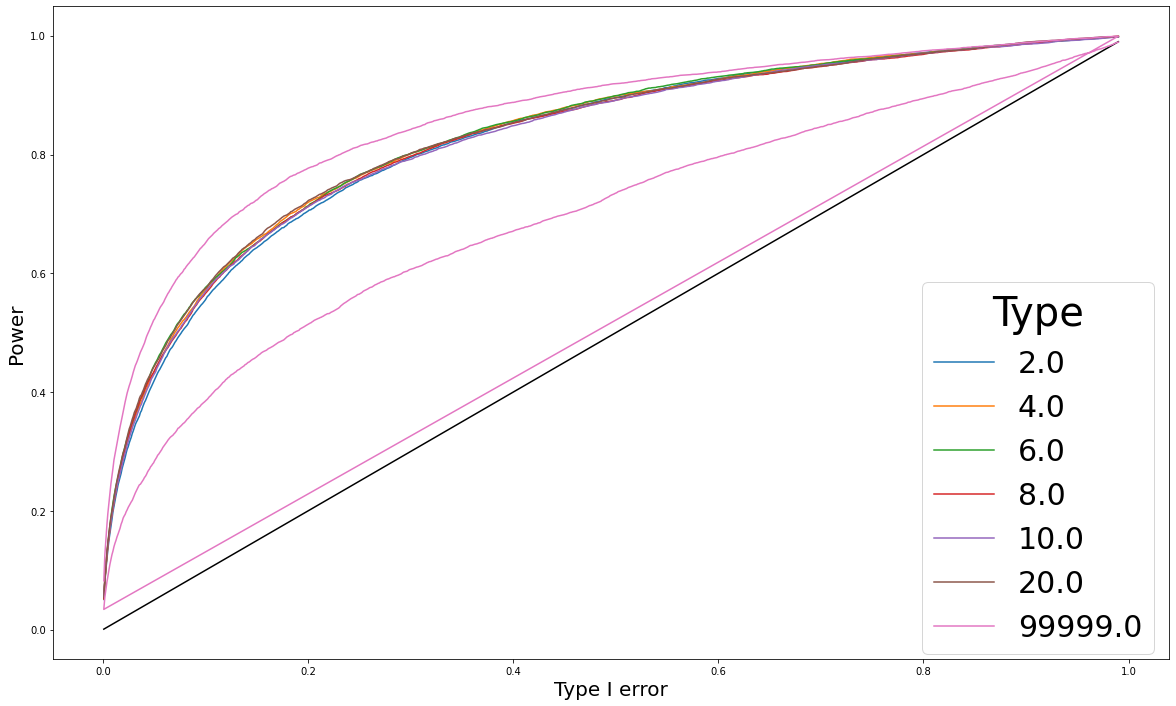

In [20]:
data['RW'] = RW
params_fixed = {'ratio_degree':1.062,
                'n':20,
                'm':20,
                'nr_nodes_1':60,
                'nr_nodes_2':60,
                'normalize':0,
                'r':4,
                'N':10000,
                'B':3000
                }

# RW.loc[(RW['tmax'] == 4) | (RW['type'].isin(['ARKL', 'ARKU_plus']))]
# RW.loc[(RW['tmax'] == 8) | (RW['type'].isin(['ARKL', 'ARKU_plus']))]
# .loc[(RW['tmax'] == 4) | (RW['type'].isin(['exponential', 'ARKU_plus']))]
plotVaryingBGDEG(df = RW, param_vary_name = "tmax", params_fixed = params_fixed, mmd_stat = "MMD_u", color_name = "tab10", disp_title=False, legend_title= 'Type')

In [21]:
params_kernel['RW'] = ['normalize', 'r', 'discount', 'type', 'tmax']
data_auc['RW'] = findAUC(keys = keys, params = params_kernel['RW'], stats = ['MMD_b', 'MMD_u'], df = RW.loc[RW['N'] == 10000] )

## Random walk vs average degree

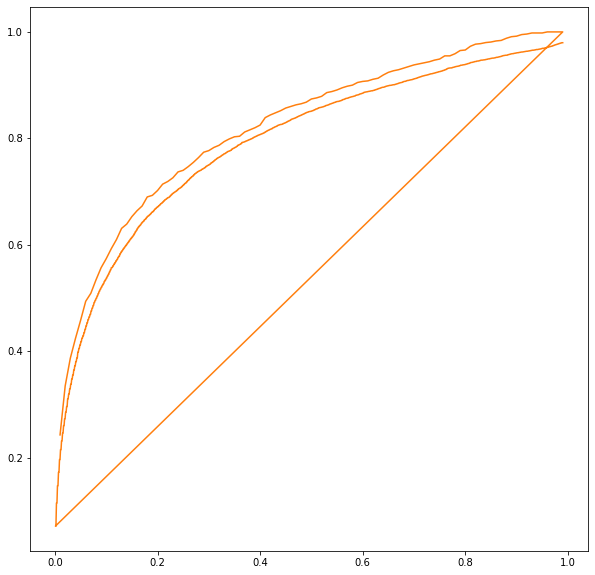

In [22]:
fig, ax = plt.subplots(1,1, figsize = (10, 10))
tmp_rw = RW.loc[(RW['tmax'] == 1) & (RW['degree_2'] == 4.25) & (RW['type'] =='p-rw')  & (RW['r'] == 2) & (RW['discount'] == 0.01)]
tmp_gs = GRAPHSTATS.loc[(GRAPHSTATS['degree_2'] == 4.25) & (GRAPHSTATS['n'] == 20) & (GRAPHSTATS['nr_nodes_1'] == 60) & (GRAPHSTATS['nr_nodes_2'] == 60) ]
ax.plot(tmp_rw['alpha'], tmp_rw['MMD_u'])
ax.plot(tmp_gs['alpha'], tmp_gs['average_degree'])

# Shortest Path

In [23]:
SP = readfoldertopandaWL("../data/BGDegreeLabel/SP")
SP = SP.loc[(SP['N'] == 10000) | (SP['N'] == 3000)]
SP = SP.loc[(SP['kernel'] == "[{'name': 'SP', 'with_labels': False}]") | (SP['kernel'] == "[{'name': 'SP', 'with_labels': True}]")]

norm is 0
norm is 0
norm is 0
norm is 0
norm is 0
norm is 0
norm is 0
norm is 0
norm is 0
norm is 0


In [24]:
np.unique(SP['N'])

array([ 3000, 10000], dtype=int64)

C:/Users/User/Code/MMDGraph\mmdutils.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[param_vary_name].fillna(value=99999, inplace=True)


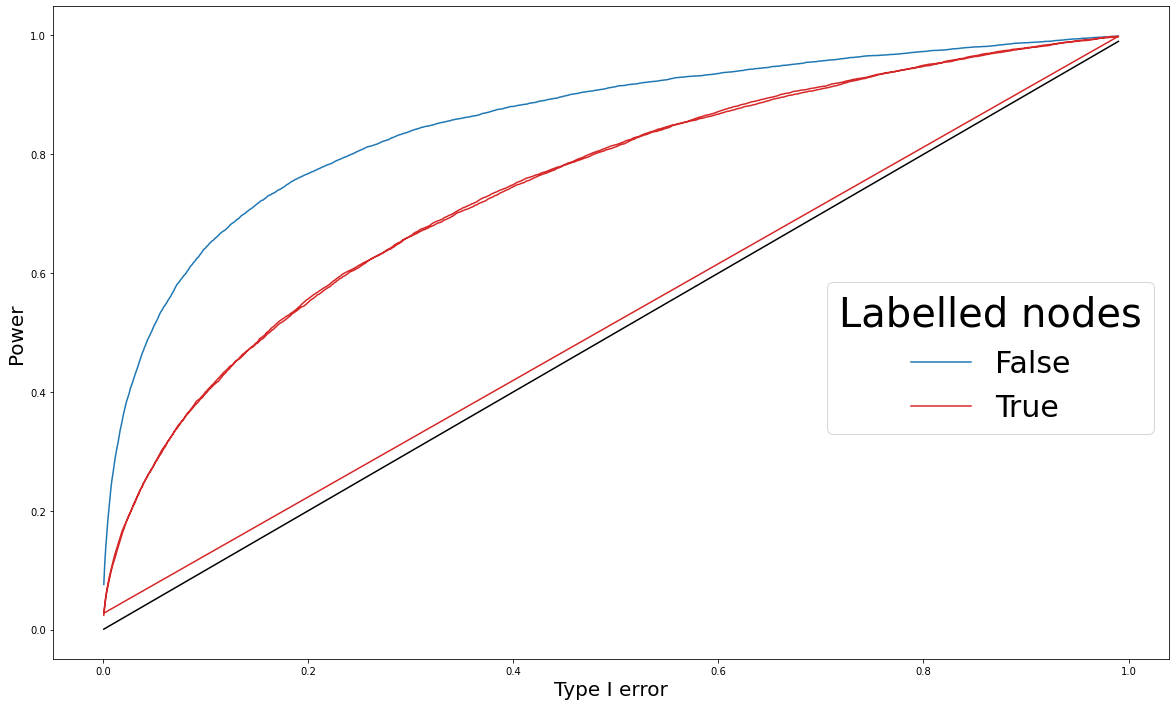

In [25]:
data['SP'] = SP
params_fixed = {'ratio_degree': 1.062,
                'n':20,
                'm':20,
                'nr_nodes_1':60,
                'nr_nodes_2':60,
                'normalize':0
                }


plotVaryingBGDEG(df = SP.copy(), param_vary_name = "with_labels", params_fixed = params_fixed, mmd_stat = "MMD_u", color_name = "tab10", disp_title=False, legend_title= 'Labelled nodes')

In [26]:
params_kernel['SP'] = ['normalize', 'with_labels']
data_auc['SP'] = findAUC(keys = keys, params = params_kernel['SP'], stats = ['MMD_b', 'MMD_u'], df = SP )


# WWL

In [27]:
WWL = readfoldertopanda("../data/BGDegreeLabel/WWL")
WWL.columns
WWL = WWL.loc[(WWL['N'] == 10000) | (WWL['N'] == 3000)]



In [28]:
# Because of some changes I created different coLumns for same parameter. I need to put all the information into one parameter

WWL.loc[WWL['nitr'].isna(), 'nitr'] = WWL.loc[WWL['nitr'].isna(), 'wl_itr']



In [29]:
np.unique(WWL['n'])

array([ 20,  40,  60,  80, 100, 150], dtype=int64)

C:/Users/User/Code/MMDGraph\mmdutils.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[param_vary_name].fillna(value=99999, inplace=True)


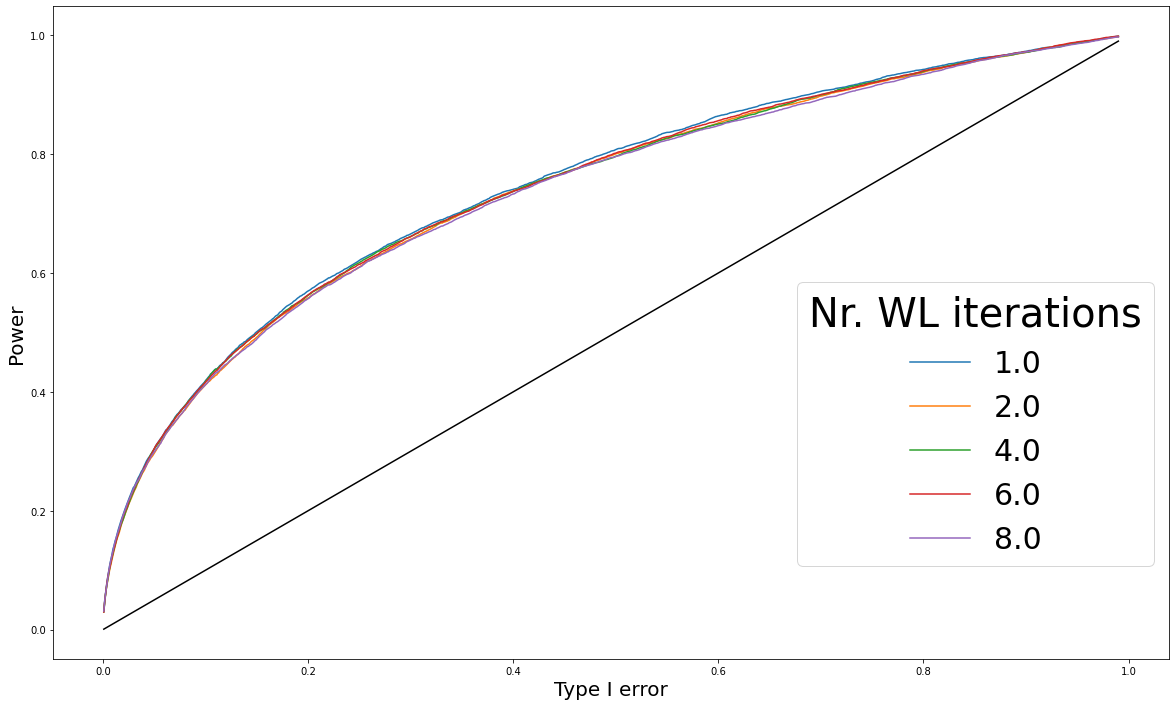

In [30]:
data['WWL'] = WWL
params_fixed = {'ratio_degree':sorted(np.unique(WWL['ratio_degree']))[0],
                'n':20,
                'm':20,
                'N':10000,
                'nr_nodes_1':60,
                'nr_nodes_2':60,
                'normalize':0,
                'discount':0.1
                #'nitr':4
                }

plotVaryingBGDEG(df = WWL.copy(), param_vary_name = "nitr", params_fixed = params_fixed, mmd_stat = "MMD_u", color_name = "tab10", disp_title=False, legend_title= 'Nr. WL iterations')

In [31]:
WWL.columns

Index(['kernel', 'alpha', 'normalize', 'nr_nodes_1', 'nr_nodes_2', 'p_edge_1',
       'p_edge_2', 'degree_1', 'degree_2', 'ratio_p', 'ratio_degree', 'n', 'm',
       'timestap', 'B', 'N', 'run_time', 'MMD_b', 'MMD_b_distfree', 'MMD_u',
       'MMD_u_distfree', 'nitr', 'with_labels', 'discount', 'sinkhorn',
       'wl_itr', 'average_degree', 'median_degree', 'avg_neigh_degree',
       'avg_clustering', 'transitivity'],
      dtype='object')

In [32]:
params_kernel['WWL'] = ['normalize', 'sinkhorn', 'discount', 'nitr']
data_auc['WWL'] = findAUC(keys = keys, params = params_kernel['WWL'], stats = ['MMD_b', 'MMD_u'], df = WWL.loc[WWL['N'] == 10000] )


# Propagation

In [33]:
PROP = readfoldertopanda("../data/BGDegreeLabel/PROP")
PROP = PROP.loc[(PROP['N'] == 10000) | (PROP['N'] == 3000)]
PROP.columns


Index(['kernel', 'alpha', 'normalize', 'nr_nodes_1', 'nr_nodes_2', 'p_edge_1',
       'p_edge_2', 'degree_1', 'degree_2', 'ratio_p', 'ratio_degree', 'n', 'm',
       'timestap', 'B', 'N', 'run_time', 'MMD_b', 'MMD_b_distfree', 'MMD_u',
       'MMD_u_distfree', 'with_labels', 'w', 'tmax', 'M', 'sinkhorn', 't_max',
       'binwidth', 'M_distance', 'average_degree', 'median_degree',
       'avg_neigh_degree', 'avg_clustering', 'transitivity'],
      dtype='object')

In [34]:
# Because of some changes I created different coumns for same parameter. I need to put all the information into one parameter

PROP.loc[PROP['w'].isna(), 'w'] = PROP.loc[PROP['w'].isna(), 'binwidth']
PROP.loc[PROP['tmax'].isna(), 'tmax'] = PROP.loc[PROP['tmax'].isna(), 't_max']
PROP.loc[PROP['M'].isna(), 'M'] = PROP.loc[PROP['M'].isna(), 'M_distance']

In [35]:
print(np.unique(df['n']))
print(np.unique(df['m']))
print(np.unique(df['nr_nodes_1']))
print(np.unique(df['nr_nodes_2']))

[ 10  20  40  60 100]
[ 10  20  40  60 100]
[20 60 80]
[20 60 65 70 75 80 90]


C:/Users/User/Code/MMDGraph\mmdutils.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[param_vary_name].fillna(value=99999, inplace=True)


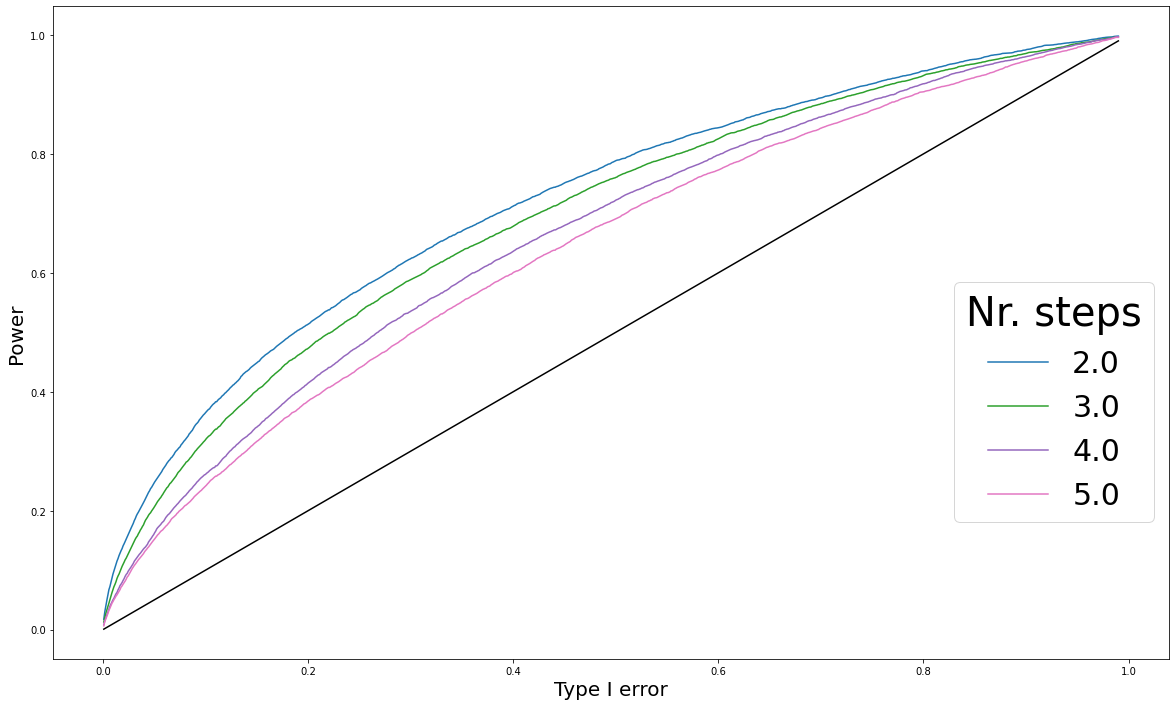

In [36]:
#print(sorted(np.unique(df['ratio_degree']))[0])
data['PROP'] = PROP
params_fixed = {'ratio_degree':sorted(np.unique(PROP['ratio_degree']))[0],
                'n':20,
                'm':20,
                'N':10000,
                'nr_nodes_1':60,
                'nr_nodes_2':60,
                'normalize':0,
                'w':0.1

                }

plotVaryingBGDEG(df = PROP.copy(), param_vary_name = "tmax", params_fixed = params_fixed, mmd_stat = "MMD_u", color_name = "tab10", disp_title=False, legend_title= 'Nr. steps')

Will reject more often with lower width

C:/Users/User/Code/MMDGraph\mmdutils.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[param_vary_name].fillna(value=99999, inplace=True)


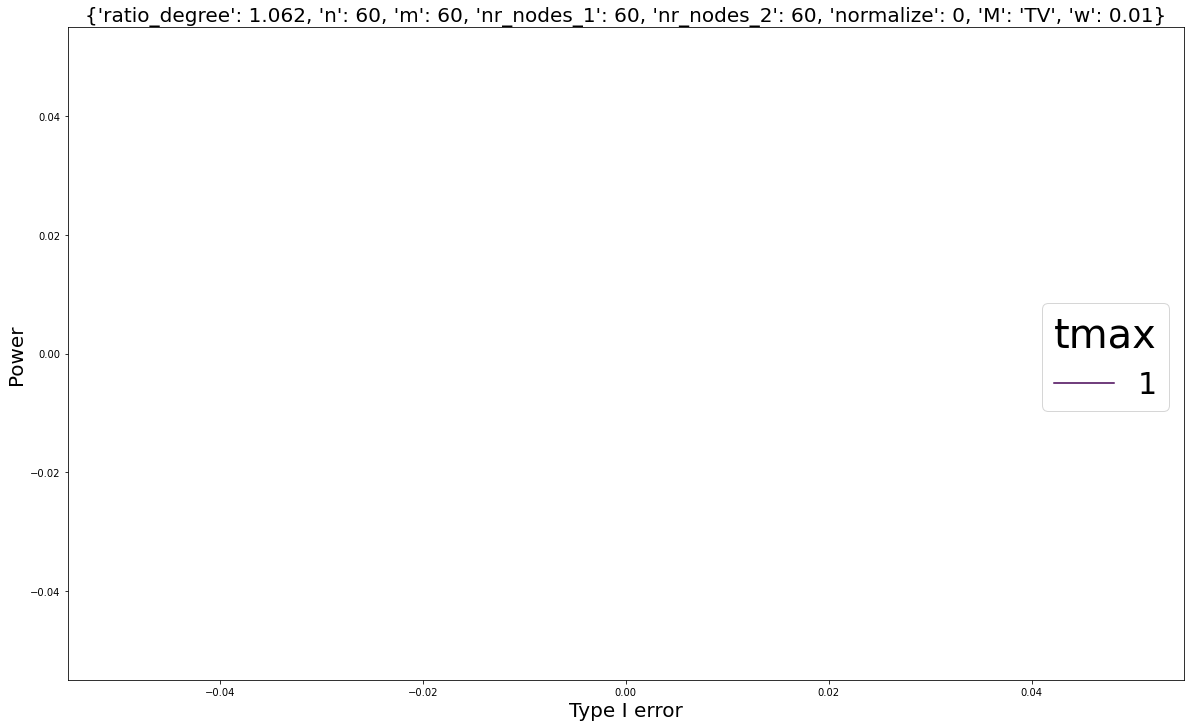

In [37]:

#print(sorted(np.unique(df['ratio_degree']))[0])
params_fixed = {'ratio_degree':sorted(np.unique(df['ratio_degree']))[0],
                'n':60,
                'm':60,
                'nr_nodes_1':60,
                'nr_nodes_2':60,
                'normalize':0,
                'M':'TV',
                'w':0.01
                }

plotVaryingBGDEG(df = PROP.copy(), param_vary_name = "tmax", params_fixed = params_fixed, mmd_stat = "MMD_b", color_name = "viridis")

tmax does not matter for degree labels

In [38]:
params_kernel['PROP'] = ['normalize', 'tmax', 'w', 'M']
data_auc['PROP'] = findAUC(keys = keys, params = params_kernel['PROP'], stats = ['MMD_b', 'MMD_u'], df = PROP.loc[PROP['N'] == 10000] )

# Pyramid

In [39]:
PYRAMID = readfoldertopanda("../data/BGDegreeLabel/PYRAMID")
PYRAMID = PYRAMID.loc[(PYRAMID['N'] == 10000) | (PYRAMID['N'] == 3000)]
PYRAMID.columns
print(np.unique(PYRAMID['with_labels']))

[False  True]


In [40]:
# Because of some changes I created different columns for same parameter. I need to put all the information into one parameter

# PYRAMID.loc[PYRAMID['dim'].isna(), 'dim'] = PYRAMID.loc[PYRAMID['dim'].isna(), 'd']


C:/Users/User/Code/MMDGraph\mmdutils.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[param_vary_name].fillna(value=99999, inplace=True)


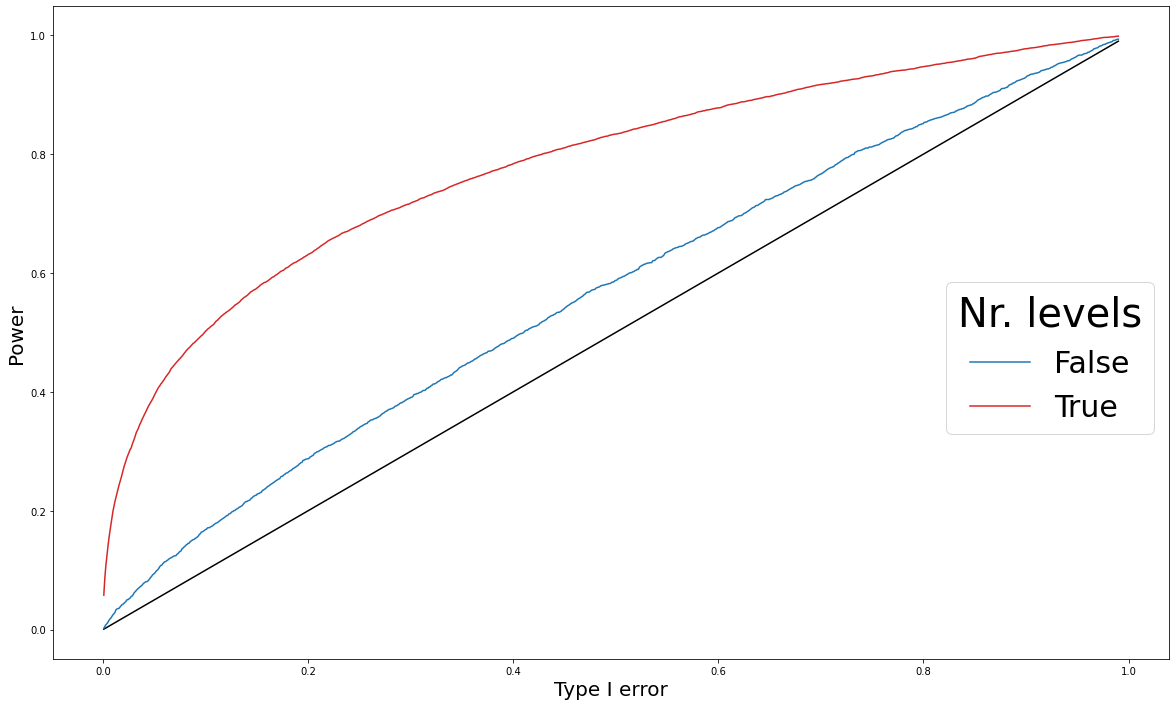

In [41]:
#print(sorted(np.unique(df['ratio_degree']))[0])
data['PYRAMID'] = PYRAMID
params_fixed = {'ratio_degree':sorted(np.unique(PYRAMID['ratio_degree']))[0],
                'n':20,
                'm':20,
                'nr_nodes_1':60,
                'nr_nodes_2':60,
                'normalize':0,
                'dim':2,
                'L':8
                }

plotVaryingBGDEG(df = PYRAMID.copy(), param_vary_name = "with_labels", params_fixed = params_fixed, mmd_stat = "MMD_u", color_name = "tab10", disp_title=False, legend_title= 'Nr. levels')

In [42]:
sorted(np.unique(df['ratio_degree']))[0]

1.062

C:/Users/User/Code/MMDGraph\mmdutils.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[param_vary_name].fillna(value=99999, inplace=True)


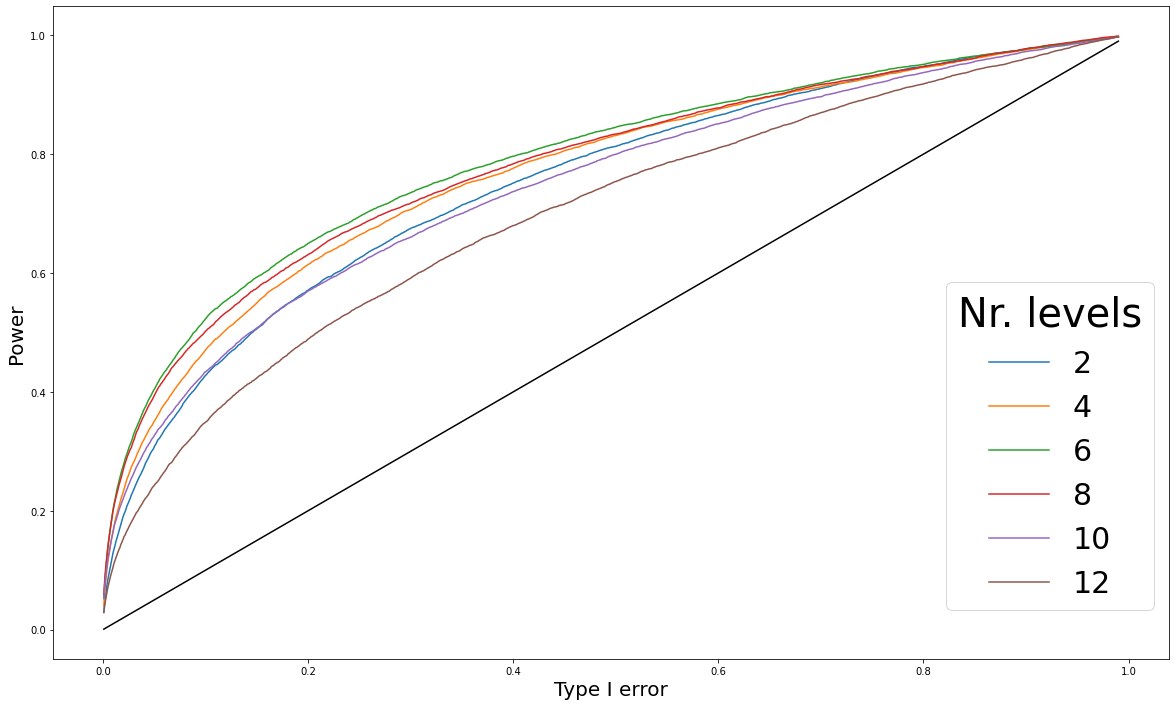

In [43]:
#print(sorted(np.unique(df['ratio_degree']))[0])
params_fixed = {'ratio_degree':sorted(np.unique(df['ratio_degree']))[0],
                'n':20,
                'm':20,
                'nr_nodes_1':60,
                'nr_nodes_2':60,
                'normalize':0,
                'dim':2,
                #'L':6,
                'with_labels':1
                }

plotVaryingBGDEG(df = PYRAMID.copy(), param_vary_name = "L", params_fixed = params_fixed, mmd_stat = "MMD_u",color_name = "tab10", disp_title=False, legend_title= 'Nr. levels')

Too large L will make the kernel very diagonally dominant.

C:/Users/User/Code/MMDGraph\mmdutils.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[param_vary_name].fillna(value=99999, inplace=True)


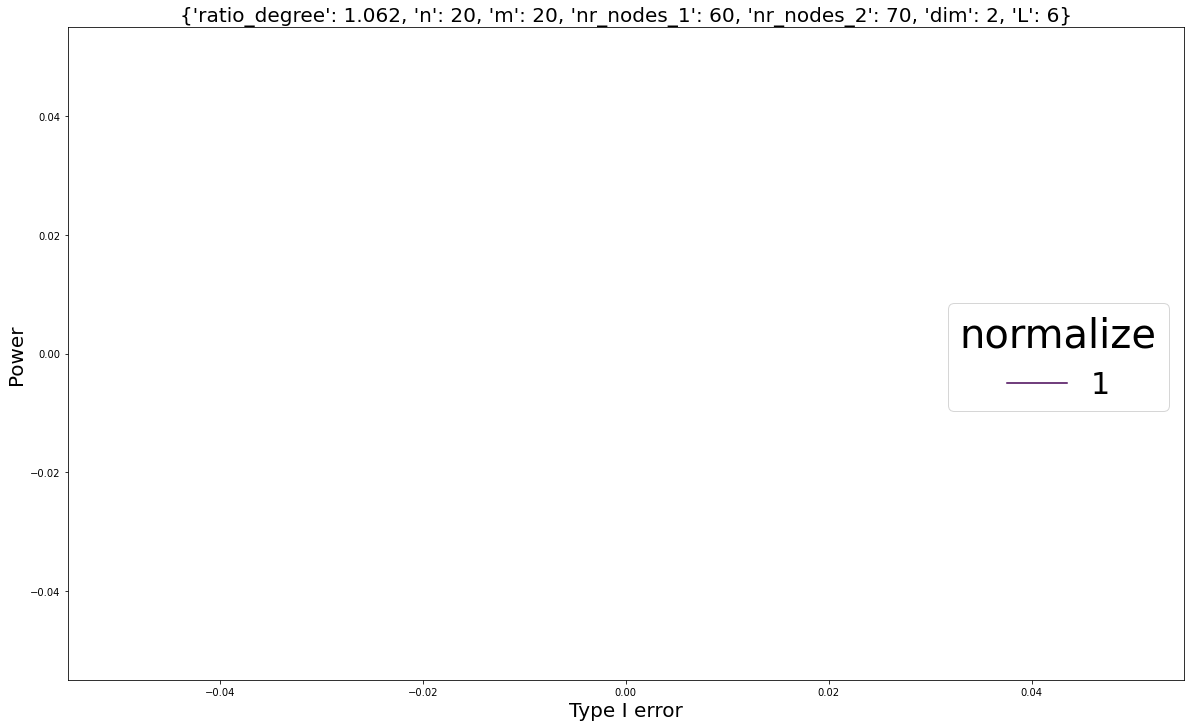

In [44]:
#print(sorted(np.unique(df['ratio_degree']))[0])
params_fixed = {'ratio_degree':sorted(np.unique(df['ratio_degree']))[0],
                'n':20,
                'm':20,
                'nr_nodes_1':60,
                'nr_nodes_2':70,
                'dim':2,
                'L':6
                }

plotVaryingBGDEG(df = PYRAMID.copy(), param_vary_name = "normalize", params_fixed = params_fixed, mmd_stat = "MMD_b", color_name = "viridis")

In [45]:
PYRAMID.columns

Index(['kernel', 'alpha', 'normalize', 'nr_nodes_1', 'nr_nodes_2', 'p_edge_1',
       'p_edge_2', 'degree_1', 'degree_2', 'ratio_p', 'ratio_degree', 'n', 'm',
       'timestap', 'B', 'N', 'run_time', 'MMD_b', 'MMD_b_distfree', 'MMD_u',
       'MMD_u_distfree', 'with_labels', 'L', 'dim', 'sinkhorn'],
      dtype='object')

In [46]:
params_kernel['PYRAMID'] = ['normalize', 'L', 'dim', 'with_labels']
data_auc['PYRAMID'] = findAUC(keys = keys, params = params_kernel['PYRAMID'], stats = ['MMD_b', 'MMD_u'], df = PYRAMID.loc[PYRAMID['N'] == 10000] )

# WLOA

In [47]:
WLOA = readfoldertopanda("../data/BGDegreeLabel/WLOA")
WLOA = WLOA.loc[(WLOA['N'] == 10000) | (WLOA['N'] == 3000)]
print(WLOA.columns)

Index(['kernel', 'alpha', 'normalize', 'nr_nodes_1', 'nr_nodes_2', 'p_edge_1',
       'p_edge_2', 'degree_1', 'degree_2', 'ratio_p', 'ratio_degree', 'n', 'm',
       'timestap', 'B', 'N', 'run_time', 'MMD_b', 'MMD_b_distfree', 'MMD_u',
       'MMD_u_distfree', 'nitr', 'with_labels', 'sinkhorn', 'wl_itr',
       'average_degree', 'median_degree', 'avg_neigh_degree', 'avg_clustering',
       'transitivity'],
      dtype='object')


In [48]:
# Because of some changes I created different columns for same parameter. I need to put all the information into one parameter

WLOA.loc[WLOA['nitr'].isna(), 'nitr'] = WLOA.loc[WLOA['nitr'].isna(), 'wl_itr']


C:/Users/User/Code/MMDGraph\mmdutils.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[param_vary_name].fillna(value=99999, inplace=True)


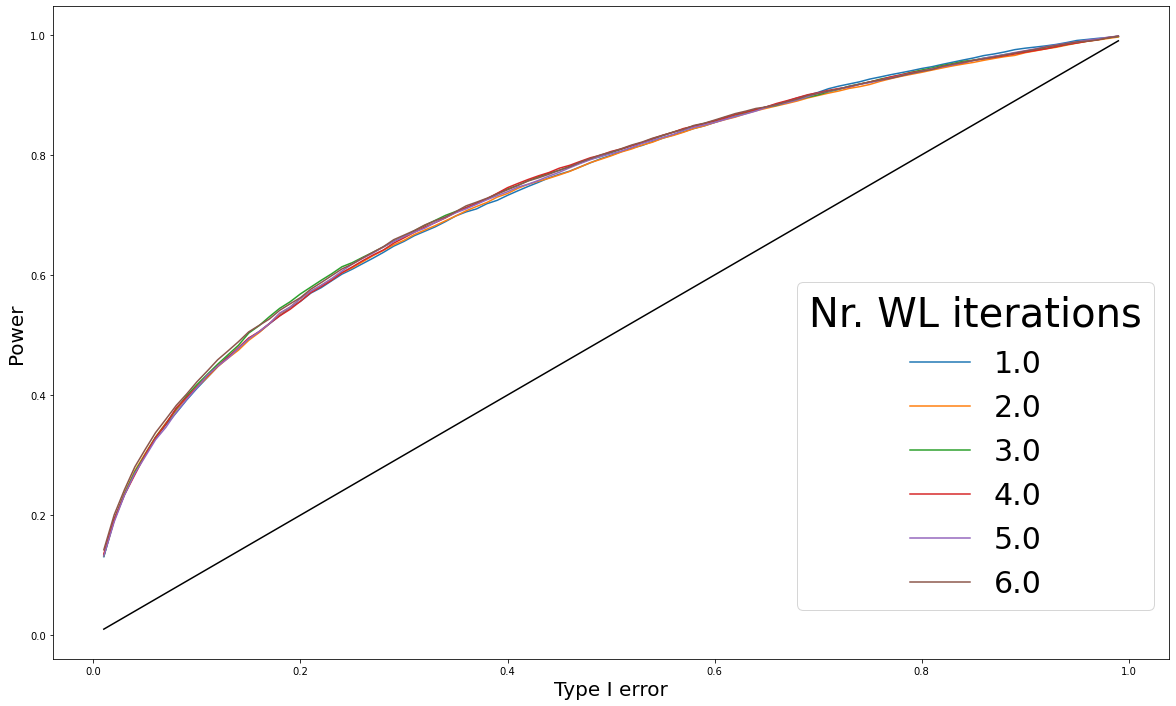

In [49]:
#print(sorted(np.unique(df['ratio_degree']))[0])
data['WLOA'] = WLOA
params_fixed = {'ratio_degree':1.062,
                'n':20,
                'm':20,
                'nr_nodes_1':60,
                'nr_nodes_2':60,
                'normalize':0,
                'N':10000
                }

plotVaryingBGDEG(df = WLOA.copy(), param_vary_name = "nitr", params_fixed = params_fixed, mmd_stat = "MMD_u", color_name = "tab10", disp_title=False, legend_title= 'Nr. WL iterations')

C:/Users/User/Code/MMDGraph\mmdutils.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[param_vary_name].fillna(value=99999, inplace=True)


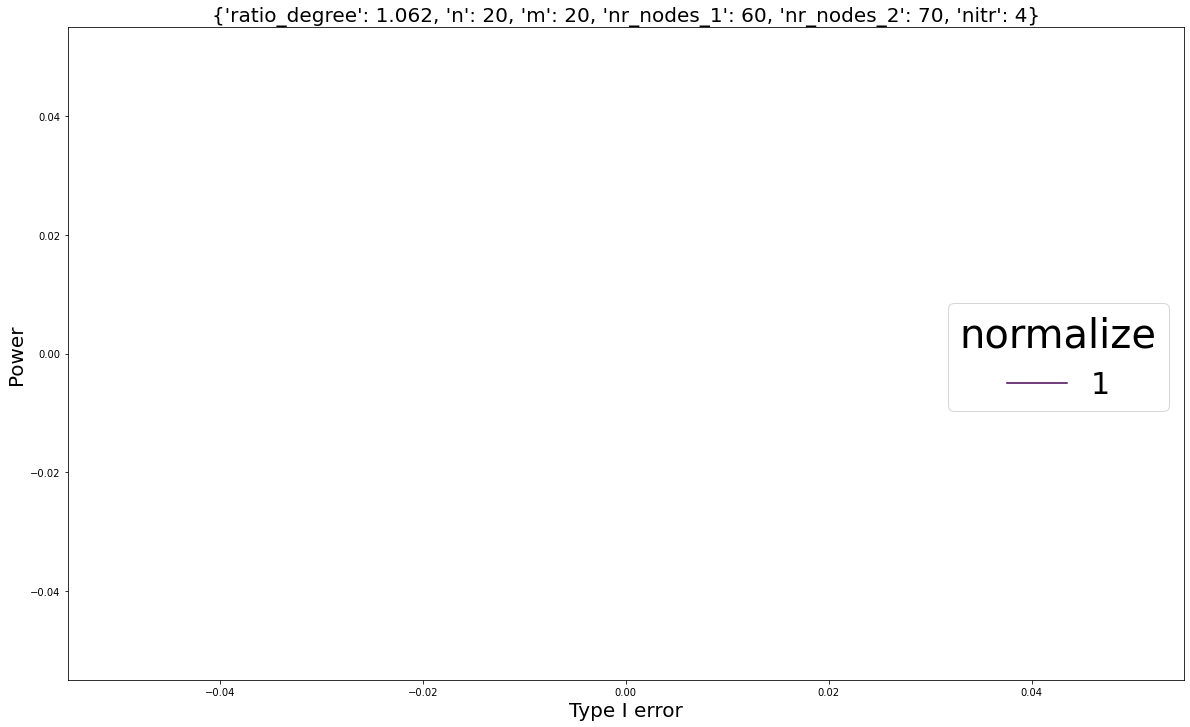

In [50]:
#print(sorted(np.unique(df['ratio_degree']))[0])
params_fixed = {'ratio_degree':sorted(np.unique(df['ratio_degree']))[0],
                'n':20,
                'm':20,
                'nr_nodes_1':60,
                'nr_nodes_2':70,
                'nitr':4
                }

plotVaryingBGDEG(df = WLOA.copy(), param_vary_name = "normalize", params_fixed = params_fixed, mmd_stat = "MMD_b", color_name = "viridis")

In [51]:
params_kernel['WLOA'] = ['normalize', 'nitr']
data_auc['WLOA'] = findAUC(keys = keys, params = params_kernel['WLOA'], stats = ['MMD_b', 'MMD_u'], df = WLOA.loc[WLOA['N'] == 10000] )

# VH

In [52]:
VH = readfoldertopanda("../data/BGDegreeLabel/VH")
print(np.unique(df['n']))
print(np.unique(df['m']))
print(np.unique(df['nr_nodes_1']))
print(np.unique(df['nr_nodes_2']))
VH = VH.loc[((VH['N'] == 10000) | (VH['N'] == 3000)) & (VH['nitr'].isna())]

# VH = pd.read_pickle("../data/BGDegreeLabel/SP/n1_20_n2_20_v1_60_v2_60_norm_0_k_0.25'")

[ 10  20  40  60 100]
[ 10  20  40  60 100]
[20 60 80]
[20 60 65 70 75 80 90]


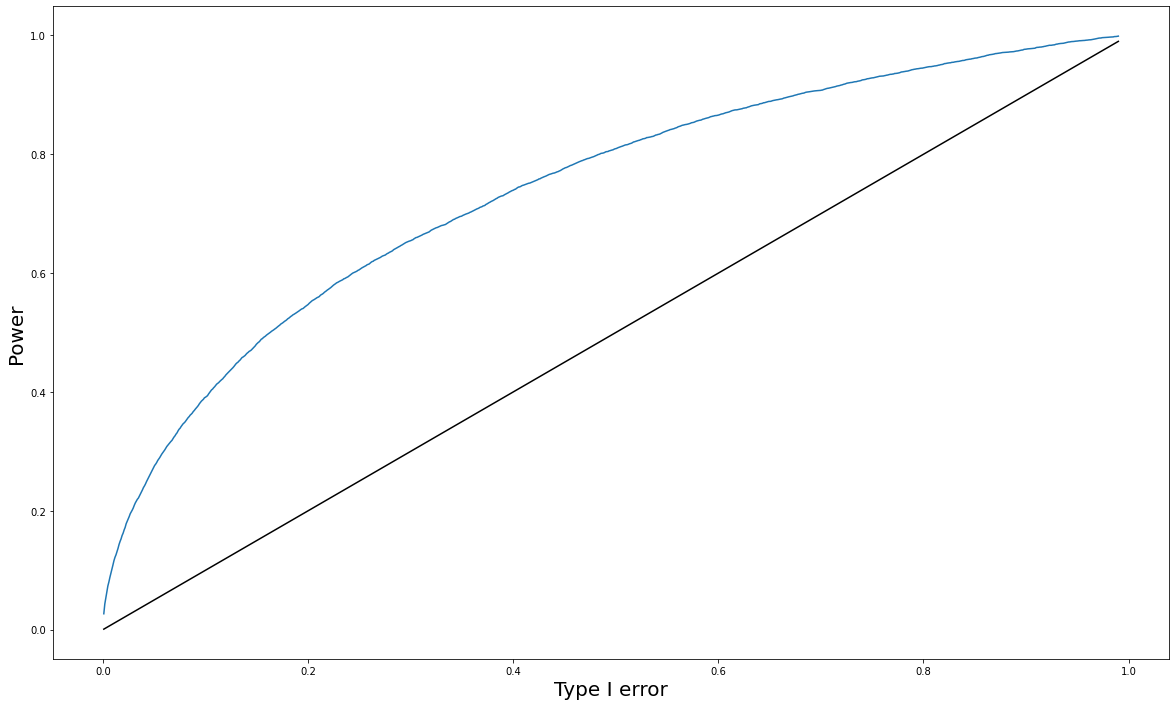

In [53]:
#print(sorted(np.unique(df['ratio_degree']))[0])
data['VH'] = VH
params_fixed = {'ratio_degree':sorted(np.unique(df['ratio_degree']))[0],
                'n':20,
                'm':20,
                'nr_nodes_1':60,
                'nr_nodes_2':60
                }

plotVaryingBGDEG(df = VH.copy(), param_vary_name = "normalize", params_fixed = params_fixed, mmd_stat = "MMD_u",color_name = "tab10", disp_title=False, legend_title= False, set_legend=False)

In [54]:
params_kernel['VH'] = ['normalize']
data_auc['VH'] = findAUC(keys = keys, params = params_kernel['VH'], stats = ['MMD_b', 'MMD_u'], df = VH )

# ODD

In [55]:
ODD = readfoldertopanda("../data/BGDegreeLabel/ODD")
print(ODD.columns)
ODD = ODD.loc[(ODD['N'] == 10000) | (ODD['N'] == 3000)]
ODD['dagh'] = ODD['dagh'].astype(str)
ODD['dagh'].loc[ODD['dagh'] == 'nan'] = 'No limit'

Index(['kernel', 'alpha', 'normalize', 'nr_nodes_1', 'nr_nodes_2', 'p_edge_1',
       'p_edge_2', 'degree_1', 'degree_2', 'ratio_p', 'ratio_degree', 'n', 'm',
       'timestap', 'B', 'N', 'run_time', 'MMD_b', 'MMD_b_distfree', 'MMD_u',
       'MMD_u_distfree', 'with_labels', 'dagh', 'sinkhorn', 'dag_depth'],
      dtype='object')


C:\Users\User\AppData\Local\Temp\ipykernel_26880\4003221816.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ODD['dagh'].loc[ODD['dagh'] == 'nan'] = 'No limit'


In [56]:
# # Because of some changes I created different coumns for same parameter. I need to put all the information into one parameter

# ODD.loc[ODD['dagh'].isna(), 'dagh'] = ODD.loc[ODD['dagh'].isna(), 'dag_depth']


C:/Users/User/Code/MMDGraph\mmdutils.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[param_vary_name].fillna(value=99999, inplace=True)


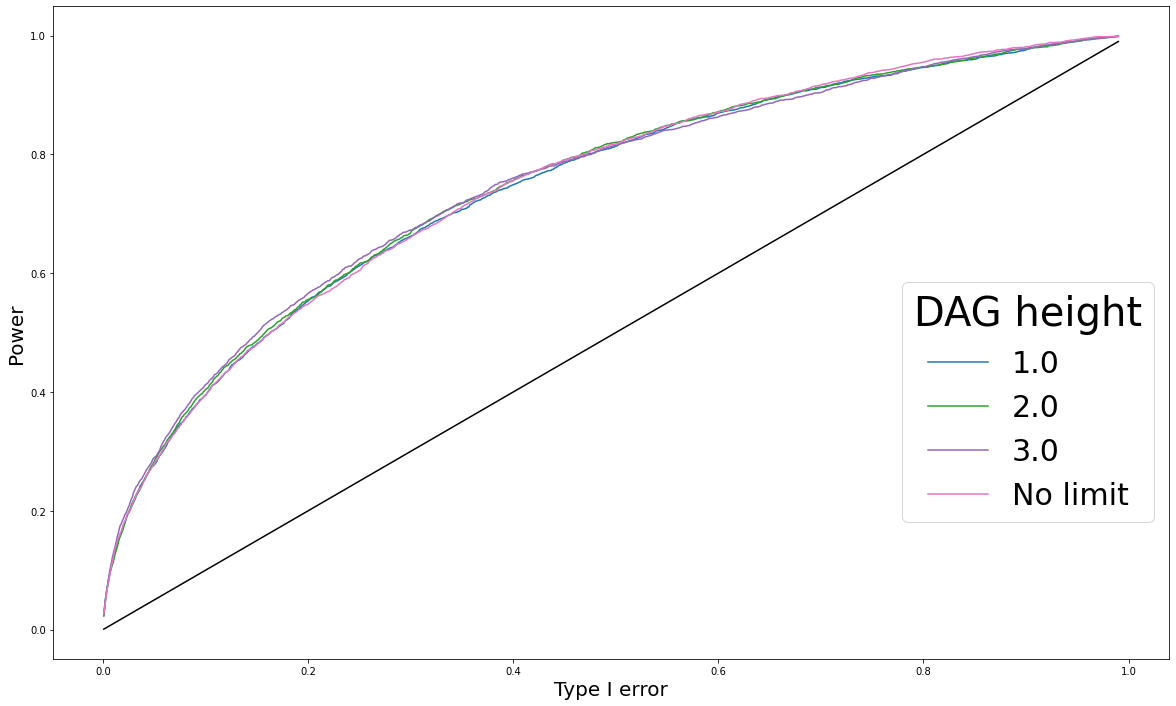

In [57]:
#print(sorted(np.unique(df['ratio_degree']))[0])
data['ODD'] = ODD
params_fixed = {'ratio_degree':sorted(np.unique(data['ODD']['ratio_degree']))[0],
                'n':20,
                'm':20,
                'nr_nodes_1':60,
                'nr_nodes_2':60,
                'normalize':0
                }

plotVaryingBGDEG(df = ODD.copy(), param_vary_name = "dagh", params_fixed = params_fixed, mmd_stat = "MMD_u", color_name = "tab10", disp_title=False, legend_title= 'DAG height')

Seems like the dag_depth should not be too high

In [58]:
params_kernel['ODD'] = ['normalize', 'dagh']
data_auc['ODD'] = findAUC(keys = keys, params = params_kernel['ODD'], stats = ['MMD_b', 'MMD_u'], df = ODD )

# DK

In [59]:
DK = readfoldertopanda("../data/BGDegreeLabel/DK")
DK = DK.loc[(DK['N'] == 10000) | (DK['N'] == 3000)]
print(DK.columns)

Index(['kernel', 'alpha', 'normalize', 'dk_type', 'wl_itr', 'nr_nodes_1',
       'nr_nodes_2', 'p_edge_1', 'p_edge_2', 'degree_1', 'degree_2', 'ratio_p',
       'ratio_degree', 'n', 'm', 'timestap', 'B', 'N', 'run_time', 'MMD_b',
       'MMD_b_distfree', 'MMD_u', 'MMD_u_distfree', 'with_labels', 'type',
       'sinkhorn', 'nitr'],
      dtype='object')


In [60]:
# Because of some changes I created different coumns for same parameter. I need to put all the information into one parameter

DK.loc[DK['type'].isna(), 'type'] = DK.loc[DK['type'].isna(), 'dk_type']
DK.loc[DK['nitr'].isna(), 'nitr'] = DK.loc[DK['nitr'].isna(), 'wl_itr']


In [61]:
np.unique(DK['type'])

array(['sp', 'wl'], dtype=object)

C:/Users/User/Code/MMDGraph\mmdutils.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[param_vary_name].fillna(value=99999, inplace=True)


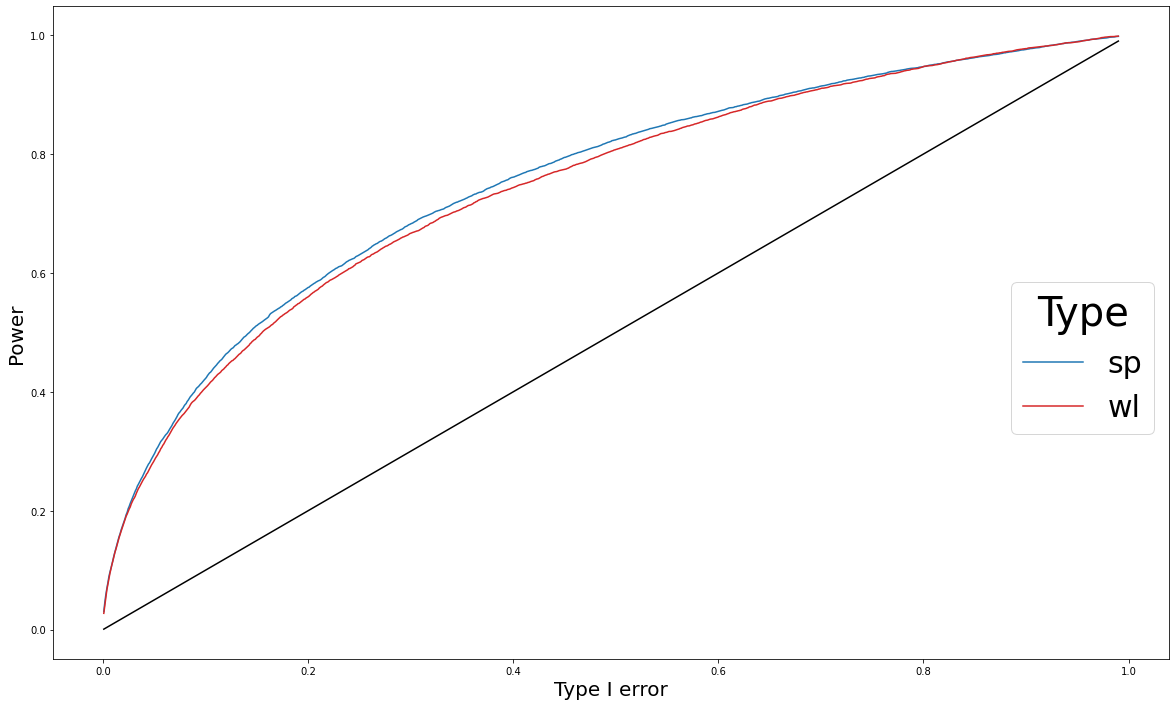

In [62]:
#print(sorted(np.unique(df['ratio_degree']))[0])
data['DK'] = DK
params_fixed = {'ratio_degree':1.062,
                'n':20,
                'm':20,
                'nr_nodes_1':60,
                'nr_nodes_2':60,
                'normalize':0}
plotVaryingBGDEG(df = DK, param_vary_name = "type", params_fixed = params_fixed, mmd_stat = "MMD_u", color_name = "tab10", disp_title=False, legend_title= 'Type')

C:/Users/User/Code/MMDGraph\mmdutils.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[param_vary_name].fillna(value=99999, inplace=True)


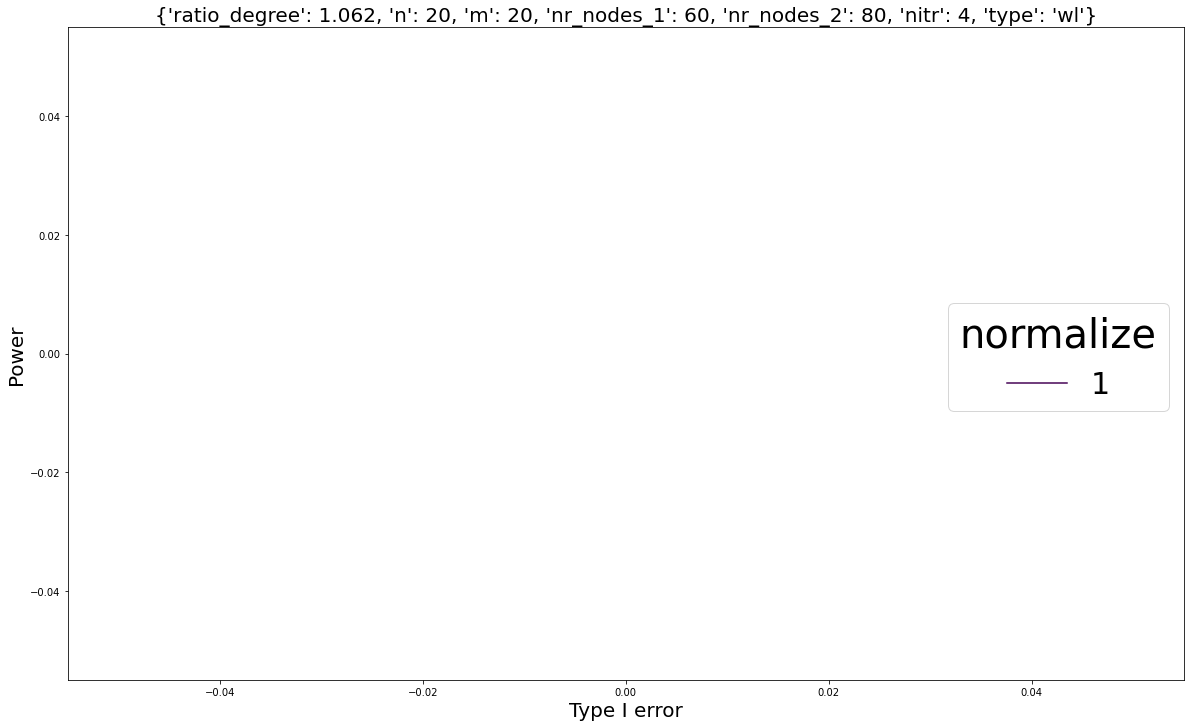

In [63]:
#print(sorted(np.unique(df['ratio_degree']))[0])
params_fixed = {'ratio_degree':sorted(np.unique(df['ratio_degree']))[0],
                'n':20,
                'm':20,
                'nr_nodes_1':60,
                'nr_nodes_2':80,
                'nitr':4,
                'type':'wl'
                }

plotVaryingBGDEG(df = DK.copy(), param_vary_name = "normalize", params_fixed = params_fixed, mmd_stat = "MMD_b", color_name = "viridis")

In [64]:
params_kernel['DK'] = ['normalize', 'type', 'nitr']
data_auc['DK'] = findAUC(keys = keys, params = params_kernel['DK'], stats = ['MMD_b', 'MMD_u'], df = DK )

# GNTK

In [65]:
GNTK = readfoldertopanda("../data/BGDegreeLabel/GNTK")
GNTK.columns

GNTK['L+R'] = GNTK['L'].astype(str) + "-" +GNTK['dim'].astype(str)

C:/Users/User/Code/MMDGraph\mmdutils.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[param_vary_name].fillna(value=99999, inplace=True)


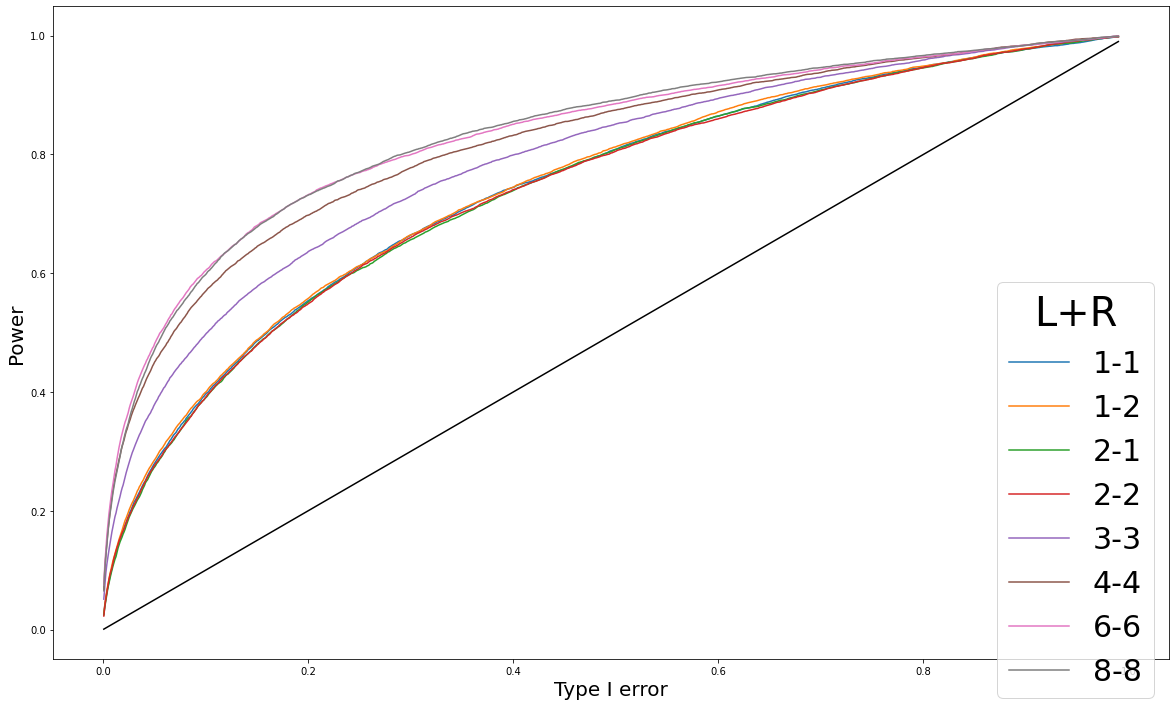

In [66]:
data['GNTK'] = GNTK
params_fixed = {'ratio_degree':1.062,
                'n':20,
                'm':20,
                'nr_nodes_1':60,
                'nr_nodes_2':60,
                'normalize':0,
                'type':'uniform',
                #'L':3,
                #'dim':3,
                'sinkhorn':1
                }

# RW.loc[(RW['tmax'] == 4) | (RW['type'].isin(['ARKL', 'ARKU_plus']))]
# RW.loc[(RW['tmax'] == 8) | (RW['type'].isin(['ARKL', 'ARKU_plus']))]
# .loc[(RW['tmax'] == 4) | (RW['type'].isin(['exponential', 'ARKU_plus']))]
plotVaryingBGDEG(df = GNTK, param_vary_name = "L+R", params_fixed = params_fixed, mmd_stat = "MMD_u", color_name = "tab10", disp_title=False, legend_title= 'L+R')

In [67]:
params_kernel['GNTK'] = ['normalize', 'L', 'dim', 'type', 'sinkhorn']
data_auc['GNTK'] = findAUC(keys = keys, params = params_kernel['GNTK'], stats = ['MMD_b', 'MMD_u'], df = GNTK )

# Comparing all with best params

In [68]:

key_pair = pd.DataFrame({'nr_nodes_1':60, 
            'nr_nodes_2':60, 
            'degree_1':4,
            'degree_2':4.25,
            'n':20, 
            'm':20}, index = [0])

stat = 'MMD_u_auc'
stat_plot = 'MMD_u'

best = []

for k,v in data.items():

    k_data_max = data_auc[k].reset_index().merge(key_pair, on = keys)
    # if k == 'PYRAMID':
    #     k_data_max = k_data_max.loc[k_data_max['L'] > 2]

    k_data_max = data_auc[k].reset_index().merge(key_pair, on = keys)

    if key_pair['nr_nodes_1'].iloc[0] != key_pair['nr_nodes_2'].iloc[0]:
        k_data_max = k_data_max[(k_data_max['normalize'] != 0)]
        k_data_max = k_data_max[k_data_max.groupby(keys)[stat].transform(max) == k_data_max[stat]].iloc[[0]]
        tmp_data = v[(v['normalize'] != 0)].reset_index().merge(k_data_max, on = keys + params_kernel[k])
    else:
        k_data_max = k_data_max[k_data_max.groupby(keys)[stat].transform(max) == k_data_max[stat]].iloc[[0]]
        tmp_data = v.loc[(v['N'] == 10000) | (v['N'] == 3000)].reset_index().merge(k_data_max, on = keys + params_kernel[k])

    tmp_data['kernel_name'] = k
    if len(tmp_data) > 0:
        best.append(tmp_data)


graph_stat = GRAPHSTATS.reset_index().merge(key_pair, on = keys)


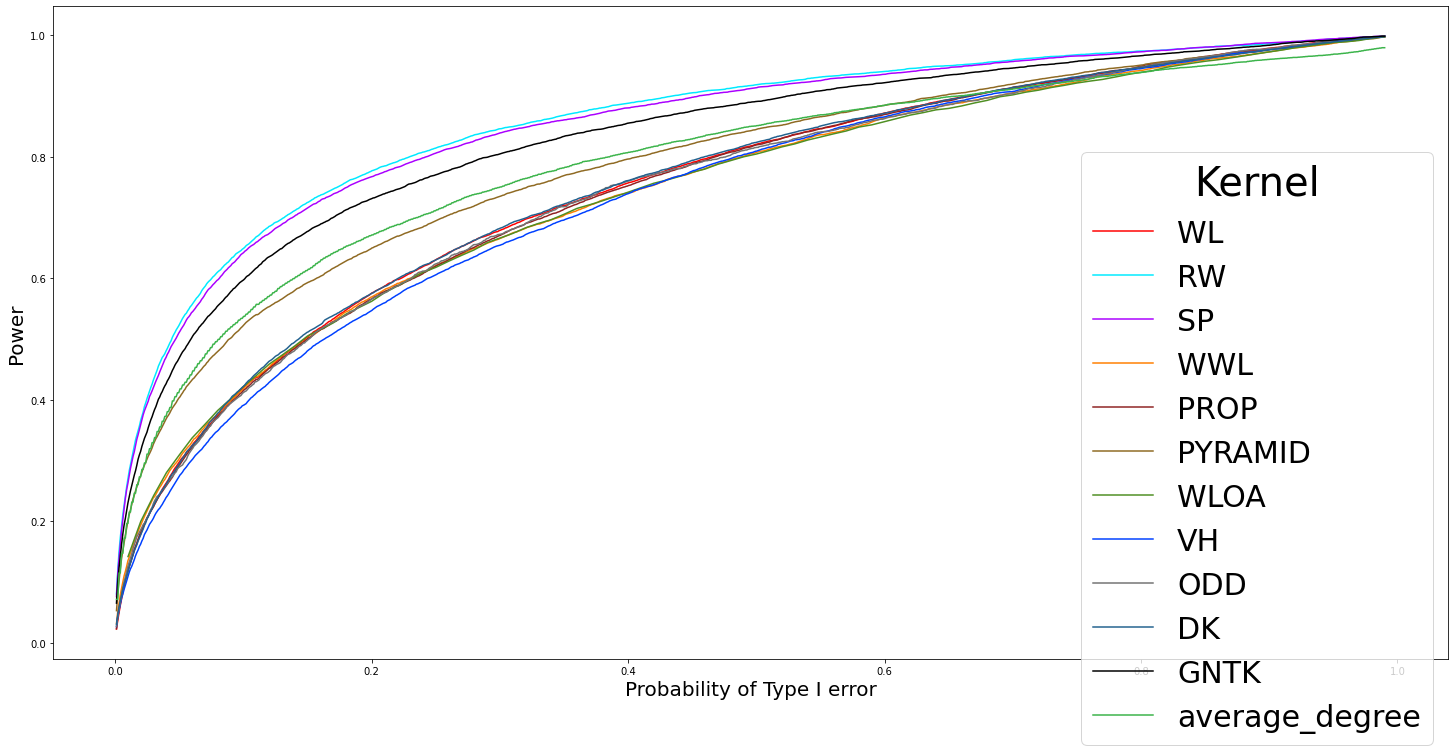

In [69]:
_, ax = plt.subplots(figsize = (25,12))


label = []
#icefire
#cmap = get_cmap(sns.color_palette("viridis", as_cmap=True)) # type: matplotlib.colors.ListedColormap
colors = ['#FF0000', '#00EAFF', '#AA00FF', '#FF7F00', '#8F2323', 
          '#8F6A23', '#4F8F23', '#0040FF', '#737373', '#23628F', 
          '#000000', '#808000', '#3cb44b']# cmap.colors[::int(len(cmap.colors)/(7+1))]  # type: list

for i,row in enumerate(best):
    ax.plot(row['alpha'], row[stat_plot], color =colors[i], label=str(row['kernel_name'].iloc[0]))
    label.append(str(row['kernel_name'].iloc[0]))


ax.plot(graph_stat['alpha'].loc[graph_stat['N'] == 10000], graph_stat['average_degree'].loc[graph_stat['N'] == 10000], color =colors[len(best)+1], label='average_degree')
label.append('average_degree')



h, l = ax.get_legend_handles_labels()


ax.set
ax.legend(handles=h, labels=label, 
        handler_map = {tuple: matplotlib.legend_handler.HandlerTuple(None)}, title = 'Kernel', bbox_to_anchor=(1, 0.8), fontsize = 30, title_fontsize=40)

ax.set_xlabel('Probability of Type I error', fontsize = 20)
ax.set_ylabel('Power', fontsize = 20)
#ax.set_title(f'Number of samples = {key_pair["n"].iloc[0]}, nr.nodes 1 = {key_pair["nr_nodes_1"].iloc[0]}, nr.nodes 2 = {key_pair["nr_nodes_2"].iloc[0]}, Degree1 = {key_pair["degree_1"].iloc[0]}, Degree2 = {key_pair["degree_2"].iloc[0]}', fontsize = 20)


plt.show()

In [60]:
with open('../data/bgdeg_data_auc.pkl', 'wb') as handle:
    pickle.dump(data_auc, handle, protocol=pickle.HIGHEST_PROTOCOL)


# Compare power

In [64]:
WL.columns

Index(['kernel', 'alpha', 'normalize', 'nr_nodes_1', 'nr_nodes_2', 'p_edge_1',
       'p_edge_2', 'degree_1', 'degree_2', 'ratio_p', 'ratio_degree', 'n', 'm',
       'timestap', 'B', 'N', 'run_time', 'MMD_b', 'MMD_b_distfree', 'MMD_u',
       'MMD_u_distfree', 'nitr', 'with_labels', 'sinkhorn', 'wl_itr'],
      dtype='object')

In [113]:
WL_power = WL.loc[(WL['nitr'] == 4) & (WL['degree_1'] == 4)]
WLOA_power = WLOA.loc[WLOA['nitr'] == 4]
SP_power = SP.loc[SP['with_labels'] == 0]
WWL_power = WWL.loc[(WWL['nitr'] == 3) & (WWL['discount'] == 0.1)]
PROP_power = PROP.loc[(PROP['tmax'] == 2) & (PROP['w'] == 0.01)]
PYRAMID_power = PYRAMID.loc[(PYRAMID['L'] == 6) & (PYRAMID['dim'] == 2) & (PYRAMID['with_labels'] == True)]
DK_power = DK.loc[(DK['type'] == 'sp')]
RW_power = RW.loc[(RW['type'] == 'ARKU_plus') & (RW['r'] == 2)]

In [107]:
alphas = sorted(np.unique(WL_power['alpha']))

Text(0, 0.5, 'Power')

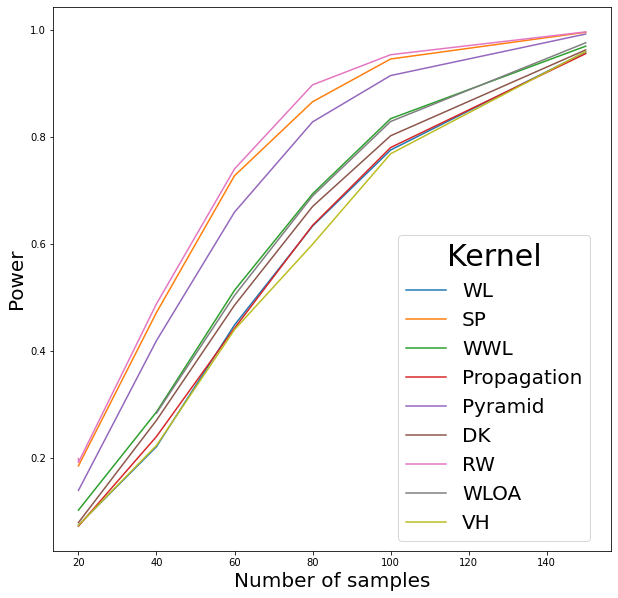

In [114]:
fig, ax = plt.subplots(1,1, figsize = (10, 10))
names  = ['WL', 'SP', 'WWL', 'Propagation', 'Pyramid', 'DK', 'RW', 'WLOA', 'VH']
for idx, data_power in enumerate([WL_power, SP_power, WWL_power, PROP_power, PYRAMID_power, DK_power, RW_power, WLOA_power, VH]):

    x = np.array(data_power['n'].loc[data_power['alpha'] == alphas[4]])
    y = np.array(data_power['MMD_u'].loc[data_power['alpha'] == alphas[4]])
    ind = np.argsort(x)
    ax.plot(x[ind],y[ind], label = names[idx])
ax.legend(title = 'Kernel', bbox_to_anchor=(0.6, 0.6), fontsize = 20, title_fontsize=30)
ax.set_xlabel('Number of samples', fontsize = 20)
ax.set_ylabel('Power', fontsize = 20)

In [112]:
np.unique(SP_power['n'])

array([20], dtype=int64)